In [1]:
import torch

In [2]:
import torch

In [3]:
from enfy import Hyperparameters
from enfy import DataModule

In [4]:
class SyntheticRegressionData(DataModule):
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val

        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise


In [5]:
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)

In [6]:
print("features:", data.X[0], "\nlabel:", data.y[0])

features: tensor([-0.2493, -0.2327]) 
label: tensor([4.4868])


# Reading the Dataset

In [7]:
import random
from enfy import add_to_class

In [8]:
@add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))

        random.shuffle(indices)

    else:
        indices = list(range(self.num_train, self.num_train + self.num_val))

    for i in range(0, len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i:i+self.batch_size])

        yield self.X[batch_indices], self.y[batch_indices]

In [9]:
X, y = next(iter(data.train_dataloader()))

In [10]:
print("X shape:", X.shape, "\ny shape:", y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


# Concise Implementation of the Data Loader

In [11]:
@add_to_class(DataModule)
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    
    dataset = torch.utils.data.TensorDataset(*tensors)

    return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)

In [12]:
@add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)

    return self.get_tensorloader((self.X, self.y), train, i)

In [13]:
X, y = next(iter(data.train_dataloader()))

In [14]:
print("X shape:", X.shape, "\ny shape:", y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


In [15]:
len(data.train_dataloader())

32

# Defining the Model

In [16]:
from enfy import Module

In [17]:
class LinearRegression(Module):
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

In [18]:
@add_to_class(LinearRegression)
def forward(self, X):
    return torch.matmul(X, self.w) + self.b

# Defining the Loss Function

In [19]:
@add_to_class(LinearRegression)
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2

    return l.mean()

# Defining the Optimization Algorithm

In [20]:
class SGD(Hyperparameters):
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [21]:
@add_to_class(LinearRegression)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

# Training

In [22]:
from enfy import Trainer

In [23]:
@add_to_class(Trainer)
def prepare_batch(self, batch):
    return batch

In [24]:
@add_to_class(Trainer)
def fit_epoch(self):
    self.model.train()

    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))

        self.optim.zero_grad()

        with torch.no_grad():
            loss.backward()

            if self.gradient_clip_val > 0:
                self.clip_gradients(self.gradient_clip_val, self.model)

            self.optim.step()

        self.train_batch_idx += 1

    if self.val_dataloader is None:
        return
    
    self.model.eval()

    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        
        self.val_batch_idx += 1


In [25]:
model = LinearRegression(2, lr=0.03)
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)

In [26]:
trainer = Trainer(max_epochs=3)

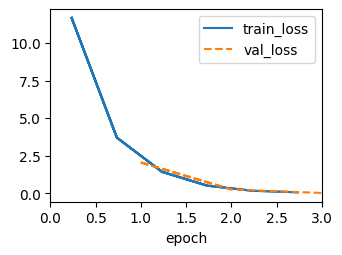

In [27]:
trainer.fit(model, data)